In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import shap

e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import shap

In [3]:

dataset_path = r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Lithium-Ion Battery Drive Cycle Dataset\2_preprocessed"

dataframes = []
csv_count = 0 

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        temperature = int(folder.split('_')[-1].replace('deg', ''))
        
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                drive_cycle = file.split('_')[1]
                df = pd.read_csv(os.path.join(folder_path, file))

                # Add metadata
                df['DriveCycle'] = drive_cycle
                df['TemperatureLabel'] = temperature
                dataframes.append(df)
                csv_count += 1

# 📌 Combine all into one DataFrame
full_df = pd.concat(dataframes, ignore_index=True)

# ✅ Print summary
print("✅ All data loaded.")
print("📁 Total CSV files loaded:", csv_count)
print("📊 Combined DataFrame shape:", full_df.shape)


✅ All data loaded.
📁 Total CSV files loaded: 60
📊 Combined DataFrame shape: (9047247, 7)


In [4]:
full_df.tail()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel
9047242,11025.7,2.656538,-3.350742,8.943850,0.125165,US06,5
9047243,11025.8,2.655582,-3.351976,8.943850,0.125146,US06,5
9047244,11025.9,2.654630,-3.353234,8.945311,0.125128,US06,5
9047245,11026.0,2.653594,-3.354528,8.947360,0.125109,US06,5
9047246,11026.1,2.450127,-9.408817,8.947360,0.125090,US06,5


In [5]:
# full_df.to_csv('full_battery_data.csv', index=False)

In [6]:
# ------------------------------------------------
# Step 2: Feature Engineering - Stress Metrics
# ------------------------------------------------
full_df['Power'] = full_df['Voltage'] * full_df['Current']
full_df['dVoltage'] = full_df['Voltage'].diff().fillna(0)
full_df['dCurrent'] = full_df['Current'].diff().fillna(0)
full_df['dPower'] = full_df['Power'].diff().fillna(0)
full_df['dTemp'] = full_df['Temperature'].diff().fillna(0)

# Avoid division by zero for IR estimate
full_df['InternalResistance'] = np.where(
    full_df['dCurrent'] != 0,
    full_df['dVoltage'] / full_df['dCurrent'],
    0
)
full_df['InternalResistance'] = full_df['InternalResistance'].clip(lower=0, upper=1)

# Clean invalid values
full_df = full_df.replace([np.inf, -np.inf], 0).dropna()

In [7]:
full_df.head(100)

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel,Power,dVoltage,dCurrent,dPower,dTemp,InternalResistance
0,0.0,4.175155,-3.691549e-06,15.96381,1.0,PDTCB,15,-1.541279e-05,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
1,0.1,4.175155,-9.512327e-07,15.96381,1.0,PDTCB,15,-3.971544e-06,0.000000,2.740316e-06,1.144124e-05,0.0,0.0
2,0.2,4.174967,-4.821614e-07,15.96381,1.0,PDTCB,15,-2.013008e-06,-0.000188,4.690713e-07,1.958536e-06,0.0,0.0
3,0.3,4.175153,-2.413463e-07,15.96381,1.0,PDTCB,15,-1.007658e-06,0.000186,2.408151e-07,1.005350e-06,0.0,1.0
4,0.4,4.174966,-8.059866e-08,15.96381,1.0,PDTCB,15,-3.364967e-07,-0.000187,1.607476e-07,6.711610e-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.5,4.174965,-3.969407e-08,15.96381,1.0,PDTCB,15,-1.657213e-07,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
96,9.6,4.174965,-3.969407e-08,15.96381,1.0,PDTCB,15,-1.657213e-07,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
97,9.7,4.175154,-3.969407e-08,15.96381,1.0,PDTCB,15,-1.657288e-07,0.000189,0.000000e+00,-7.497206e-12,0.0,0.0
98,9.8,4.174967,-3.969407e-08,15.96381,1.0,PDTCB,15,-1.657214e-07,-0.000187,0.000000e+00,7.420037e-12,0.0,0.0


In [8]:
# ------------------------------------------------
# Step 3: Encode and Normalize
# ------------------------------------------------
le = LabelEncoder()
full_df['DriveCycleEncoded'] = le.fit_transform(full_df['DriveCycle'])

features = [
    'Voltage', 'Current', 'Power',
    'dVoltage', 'dCurrent', 'dPower',
    'InternalResistance', 'dTemp',
    'TemperatureLabel', 'DriveCycleEncoded'
]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(full_df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['SOC'] = full_df['SOC'].values


In [9]:
# # ------------------------------------------------
# # Step 4: Create Time-Series Sequences for LSTM
# # ------------------------------------------------
# def create_sequences(data, target_col, window_size=20):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data.iloc[i:i+window_size].values)
#         y.append(data.iloc[i+window_size][target_col])
#     return np.array(X), np.array(y)

# window_size = 20
# X, y = create_sequences(scaled_df[features + ['SOC']], 'SOC', window_size)

# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

In [10]:
# ------------------------------------------------
# Step 4: Train ML Model (Random Forest Regressor)
# ------------------------------------------------
features = [
    'Voltage', 'Current', 'Power',
    'dVoltage', 'dCurrent', 'dPower',
    'InternalResistance', 'dTemp',
    'TemperatureLabel', 'DriveCycleEncoded'
]
X = full_df[features]
y = full_df['SOC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n📊 Model Trained. MAE: {mae:.6f}")


📊 Model Trained. MAE: 0.030790


In [ ]:
import joblib

# Save model to file
joblib.dump(model, 'rf_soc_model_random_forest.joblib')


e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


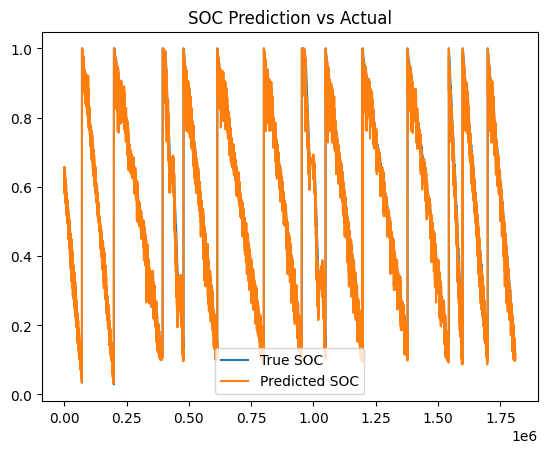

In [11]:
import matplotlib.pyplot as plt
plt.plot(y_test.values, label='True SOC')
plt.plot(y_pred, label='Predicted SOC')
plt.legend()
plt.title('SOC Prediction vs Actual')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Avg MAE: {-scores.mean():.5f}")
